# Activation Functions in Neural Networks: Comprehensive Comparison

In [1]:
# Comparing sigmoid, tanh, and ReLU activations for customer behavior classification

import torch  # Import PyTorch for neural network operations
import torch.nn as nn  # Import neural network modules from PyTorch
import matplotlib.pyplot as plt  # Import matplotlib for plotting and visualization
import numpy as np  # Import numpy for numerical operations
from torch.utils.data import Dataset, DataLoader  # Import data handling utilities
import torch.nn.functional as F  # Import functional interface for neural network operations

torch.manual_seed(42)  # Ensure reproducible results across experiments

In [2]:
# =============================================================================
# Customer Dataset (Reusing from Previous Examples)
# =============================================================================

class CustomerDataset(Dataset):  # Customer dataset for activation function comparison
    """Customer behavior dataset for activation function demonstration"""
    
    def __init__(self, num_samples=1000):  # Constructor with sample count
        self.len = num_samples  # Store dataset size
        
        # Create 4-class customer behavior dataset
        self.features = torch.zeros((num_samples, 2))  # Initialize features (time, engagement)
        self.labels = torch.zeros(num_samples, dtype=torch.long)  # Initialize class labels
        
        samples_per_class = num_samples // 4  # Samples per class
        
        for i in range(samples_per_class):  # Generate samples for each class
            # Class 0: No Purchase
            self.features[i, :] = torch.tensor([0.3, 0.3]) + 0.2 * torch.randn(2)  # Low time, low engagement
            self.labels[i] = 0  # Set class label
            
            # Class 1: Window Shopping
            self.features[i + samples_per_class, :] = torch.tensor([0.3, 0.8]) + 0.2 * torch.randn(2)  # Low time, high engagement
            self.labels[i + samples_per_class] = 1  # Set class label
            
            # Class 2: Research Purchase
            self.features[i + 2*samples_per_class, :] = torch.tensor([0.8, 0.3]) + 0.2 * torch.randn(2)  # High time, low engagement
            self.labels[i + 2*samples_per_class] = 2  # Set class label
            
            # Class 3: Impulse Purchase
            self.features[i + 3*samples_per_class, :] = torch.tensor([0.8, 0.8]) + 0.2 * torch.randn(2)  # High time, high engagement
            self.labels[i + 3*samples_per_class] = 3  # Set class label
    
    def __getitem__(self, index):  # Get single sample
        return self.features[index], self.labels[index]  # Return feature-label pair
    
    def __len__(self):  # Get dataset size
        return self.len  # Return total samples


In [3]:
# =============================================================================
# Neural Network Models Using nn.Module (Custom Class Approach)
# =============================================================================

class NetSigmoid(nn.Module):  # Neural network with sigmoid activation
    """Neural network using sigmoid activation function"""
    
    def __init__(self, input_size=2, hidden_size=128, output_size=4):  # Constructor with layer sizes
        super(NetSigmoid, self).__init__()  # Initialize parent class
        
        self.linear1 = nn.Linear(input_size, hidden_size)  # First linear layer
        self.linear2 = nn.Linear(hidden_size, output_size)  # Output layer
    
    def forward(self, x):  # Forward pass with sigmoid activation
        x = torch.sigmoid(self.linear1(x))  # Apply sigmoid to hidden layer
        x = self.linear2(x)  # Output layer (no activation for multiclass logits)
        return x  # Return logits for classification

class NetTanh(nn.Module):  # Neural network with tanh activation
    """Neural network using tanh activation function"""
    
    def __init__(self, input_size=2, hidden_size=128, output_size=4):  # Constructor with layer sizes
        super(NetTanh, self).__init__()  # Initialize parent class
        
        self.linear1 = nn.Linear(input_size, hidden_size)  # First linear layer
        self.linear2 = nn.Linear(hidden_size, output_size)  # Output layer
    
    def forward(self, x):  # Forward pass with tanh activation
        x = torch.tanh(self.linear1(x))  # Apply tanh to hidden layer
        x = self.linear2(x)  # Output layer (no activation for multiclass logits)
        return x  # Return logits for classification

class NetReLU(nn.Module):  # Neural network with ReLU activation
    """Neural network using ReLU activation function"""
    
    def __init__(self, input_size=2, hidden_size=128, output_size=4):  # Constructor with layer sizes
        super(NetReLU, self).__init__()  # Initialize parent class
        
        self.linear1 = nn.Linear(input_size, hidden_size)  # First linear layer
        self.linear2 = nn.Linear(hidden_size, output_size)  # Output layer
    
    def forward(self, x):  # Forward pass with ReLU activation
        x = torch.relu(self.linear1(x))  # Apply ReLU to hidden layer
        x = self.linear2(x)  # Output layer (no activation for multiclass logits)
        return x  # Return logits for classification


In [4]:
# =============================================================================
# Alternative Implementation Using nn.Sequential (Compact Approach)
# =============================================================================

def create_sequential_model(activation_type, input_size=2, hidden_size=128, output_size=4):  # Function to create sequential models
    """Create neural network using nn.Sequential with specified activation"""
    
    if activation_type == 'sigmoid':  # Sigmoid activation model
        model = nn.Sequential(  # Sequential container
            nn.Linear(input_size, hidden_size),  # Input to hidden layer
            nn.Sigmoid(),  # Sigmoid activation
            nn.Linear(hidden_size, output_size)  # Hidden to output layer
        )
    elif activation_type == 'tanh':  # Tanh activation model
        model = nn.Sequential(  # Sequential container
            nn.Linear(input_size, hidden_size),  # Input to hidden layer
            nn.Tanh(),  # Tanh activation
            nn.Linear(hidden_size, output_size)  # Hidden to output layer
        )
    elif activation_type == 'relu':  # ReLU activation model
        model = nn.Sequential(  # Sequential container
            nn.Linear(input_size, hidden_size),  # Input to hidden layer
            nn.ReLU(),  # ReLU activation
            nn.Linear(hidden_size, output_size)  # Hidden to output layer
        )
    else:  # Invalid activation type
        raise ValueError("Activation must be 'sigmoid', 'tanh', or 'relu'")  # Error for invalid input
    
    return model  # Return created model

In [5]:
# =============================================================================
# Training Function with Performance Tracking
# =============================================================================

def train_activation_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name):  # Training with performance tracking
    """Train model with specified activation and track performance metrics"""
    
    train_losses = []  # Track training loss over epochs
    val_accuracies = []  # Track validation accuracy over epochs
    
    print(f"\nTraining {model_name} model...")  # Progress indicator
    
    for epoch in range(num_epochs):  # Loop through training epochs
        # Training phase
        model.train()  # Set model to training mode
        epoch_loss = 0.0  # Accumulate training loss for current epoch
        
        for batch_x, batch_y in train_loader:  # Process training batches
            optimizer.zero_grad()  # Clear gradients from previous iteration
            
            predictions = model(batch_x)  # Forward pass through model
            loss = criterion(predictions, batch_y)  # Calculate loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Update model parameters
            
            epoch_loss += loss.item()  # Accumulate loss for this batch
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        correct_predictions = 0  # Count correct predictions
        total_samples = 0  # Count total samples
        
        with torch.no_grad():  # Disable gradient computation for validation
            for val_x, val_y in val_loader:  # Process validation batches
                val_predictions = model(val_x)  # Get validation predictions
                predicted_classes = torch.argmax(val_predictions, dim=1)  # Convert to class predictions
                
                correct_predictions += (predicted_classes == val_y).sum().item()  # Count correct predictions
                total_samples += val_y.size(0)  # Count total samples
        
        # Calculate metrics for this epoch
        avg_loss = epoch_loss / len(train_loader)  # Average loss per batch
        val_accuracy = correct_predictions / total_samples  # Validation accuracy
        
        train_losses.append(avg_loss)  # Store training loss
        val_accuracies.append(val_accuracy)  # Store validation accuracy
        
        # Print progress every 20 epochs
        if (epoch + 1) % 20 == 0:  # Progress reporting
            print(f'  Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    return train_losses, val_accuracies  # Return training metrics

In [6]:
# =============================================================================
# Activation Function Analysis and Visualization
# =============================================================================

def plot_activation_functions():  # Function to visualize activation functions and their derivatives
    """Plot activation functions and their derivatives for comparison"""
    
    z = torch.linspace(-5, 5, 1000)  # Input range for plotting
    
    # Calculate activation functions
    sigmoid_vals = torch.sigmoid(z)  # Sigmoid function values
    tanh_vals = torch.tanh(z)  # Tanh function values
    relu_vals = torch.relu(z)  # ReLU function values
    
    # Calculate derivatives
    sigmoid_derivs = sigmoid_vals * (1 - sigmoid_vals)  # Sigmoid derivative
    tanh_derivs = 1 - tanh_vals ** 2  # Tanh derivative
    relu_derivs = (z > 0).float()  # ReLU derivative (step function)
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Create 2x3 subplot grid
    
    # Plot activation functions
    axes[0, 0].plot(z.numpy(), sigmoid_vals.numpy(), 'b-', linewidth=2, label='Sigmoid')  # Sigmoid plot
    axes[0, 0].set_title('Sigmoid Activation')  # Title
    axes[0, 0].set_xlabel('Input (z)')  # X-axis label
    axes[0, 0].set_ylabel('Output')  # Y-axis label
    axes[0, 0].grid(True, alpha=0.3)  # Add grid
    axes[0, 0].axhline(y=0, color='k', linestyle='-', alpha=0.3)  # Horizontal line at y=0
    axes[0, 0].axvline(x=0, color='k', linestyle='-', alpha=0.3)  # Vertical line at x=0
    
    axes[0, 1].plot(z.numpy(), tanh_vals.numpy(), 'g-', linewidth=2, label='Tanh')  # Tanh plot
    axes[0, 1].set_title('Tanh Activation')  # Title
    axes[0, 1].set_xlabel('Input (z)')  # X-axis label
    axes[0, 1].set_ylabel('Output')  # Y-axis label
    axes[0, 1].grid(True, alpha=0.3)  # Add grid
    axes[0, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)  # Horizontal line at y=0
    axes[0, 1].axvline(x=0, color='k', linestyle='-', alpha=0.3)  # Vertical line at x=0
    
    axes[0, 2].plot(z.numpy(), relu_vals.numpy(), 'r-', linewidth=2, label='ReLU')  # ReLU plot
    axes[0, 2].set_title('ReLU Activation')  # Title
    axes[0, 2].set_xlabel('Input (z)')  # X-axis label
    axes[0, 2].set_ylabel('Output')  # Y-axis label
    axes[0, 2].grid(True, alpha=0.3)  # Add grid
    axes[0, 2].axhline(y=0, color='k', linestyle='-', alpha=0.3)  # Horizontal line at y=0
    axes[0, 2].axvline(x=0, color='k', linestyle='-', alpha=0.3)  # Vertical line at x=0
    
    # Plot derivatives
    axes[1, 0].plot(z.numpy(), sigmoid_derivs.numpy(), 'b--', linewidth=2, label="Sigmoid'")  # Sigmoid derivative
    axes[1, 0].set_title("Sigmoid Derivative")  # Title
    axes[1, 0].set_xlabel('Input (z)')  # X-axis label
    axes[1, 0].set_ylabel("Derivative")  # Y-axis label
    axes[1, 0].grid(True, alpha=0.3)  # Add grid
    axes[1, 0].axhline(y=0, color='k', linestyle='-', alpha=0.3)  # Horizontal line at y=0
    axes[1, 0].axvline(x=0, color='k', linestyle='-', alpha=0.3)  # Vertical line at x=0
    
    axes[1, 1].plot(z.numpy(), tanh_derivs.numpy(), 'g--', linewidth=2, label="Tanh'")  # Tanh derivative
    axes[1, 1].set_title("Tanh Derivative")  # Title
    axes[1, 1].set_xlabel('Input (z)')  # X-axis label
    axes[1, 1].set_ylabel("Derivative")  # Y-axis label
    axes[1, 1].grid(True, alpha=0.3)  # Add grid
    axes[1, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)  # Horizontal line at y=0
    axes[1, 1].axvline(x=0, color='k', linestyle='-', alpha=0.3)  # Vertical line at x=0
    
    axes[1, 2].plot(z.numpy(), relu_derivs.numpy(), 'r--', linewidth=2, label="ReLU'")  # ReLU derivative
    axes[1, 2].set_title("ReLU Derivative")  # Title
    axes[1, 2].set_xlabel('Input (z)')  # X-axis label
    axes[1, 2].set_ylabel("Derivative")  # Y-axis label
    axes[1, 2].grid(True, alpha=0.3)  # Add grid
    axes[1, 2].axhline(y=0, color='k', linestyle='-', alpha=0.3)  # Horizontal line at y=0
    axes[1, 2].axvline(x=0, color='k', linestyle='-', alpha=0.3)  # Vertical line at x=0
    
    plt.tight_layout()  # Adjust subplot spacing
    plt.show()  # Display plots

=== Activation Functions Comparison: Sigmoid vs Tanh vs ReLU ===
Dataset: 800 samples (560 train, 240 val)
Model architecture: 2 -> 128 -> 4

Visualizing activation functions and their derivatives...


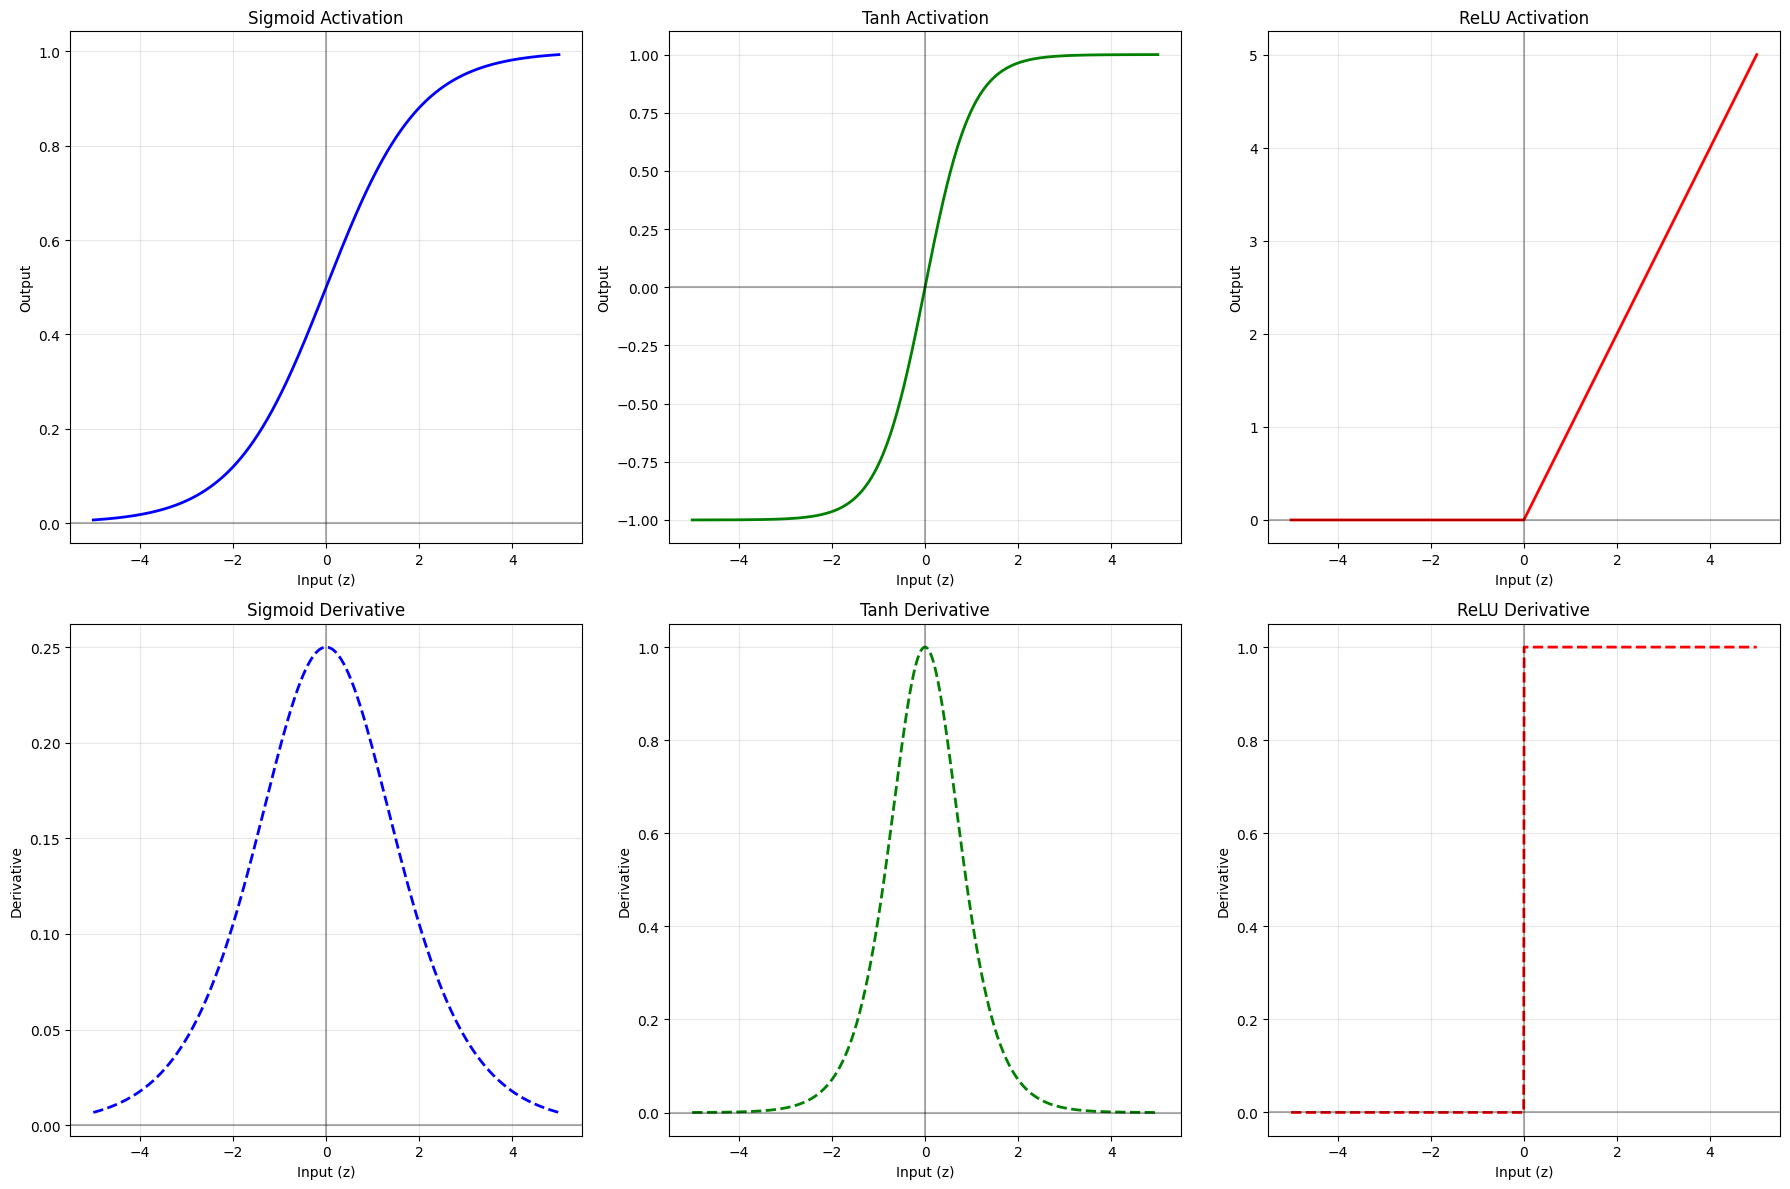

In [7]:
# =============================================================================
# Experiment: Compare All Three Activation Functions
# =============================================================================

print("=== Activation Functions Comparison: Sigmoid vs Tanh vs ReLU ===")

# Create dataset and data loaders
dataset = CustomerDataset(num_samples=800)  # Create customer dataset
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = len(dataset) - train_size  # 30% for validation

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])  # Split dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Training data loader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # Validation data loader

# Model hyperparameters
input_size = 2  # Two input features
hidden_size = 128  # Hidden layer size
output_size = 4  # Four output classes
num_epochs = 100  # Training epochs
learning_rate = 0.01  # Learning rate

print(f"Dataset: {len(dataset)} samples ({len(train_dataset)} train, {len(val_dataset)} val)")
print(f"Model architecture: {input_size} -> {hidden_size} -> {output_size}")

# Plot activation functions first
print(f"\nVisualizing activation functions and their derivatives...")
plot_activation_functions()  # Show activation function plots

In [8]:
# =============================================================================
# Train Models Using nn.Module Approach
# =============================================================================

print(f"\n--- Training Models Using nn.Module Approach ---")

# Initialize models
sigmoid_model = NetSigmoid(input_size, hidden_size, output_size)  # Sigmoid model
tanh_model = NetTanh(input_size, hidden_size, output_size)  # Tanh model
relu_model = NetReLU(input_size, hidden_size, output_size)  # ReLU model

# Define criterion
criterion = nn.CrossEntropyLoss()  # Multiclass loss function

# Train sigmoid model
optimizer_sigmoid = torch.optim.Adam(sigmoid_model.parameters(), lr=learning_rate)  # Optimizer for sigmoid
sigmoid_losses, sigmoid_accuracies = train_activation_model(  # Train sigmoid model
    sigmoid_model, train_loader, val_loader, criterion, optimizer_sigmoid, num_epochs, "Sigmoid"
)

# Train tanh model
optimizer_tanh = torch.optim.Adam(tanh_model.parameters(), lr=learning_rate)  # Optimizer for tanh
tanh_losses, tanh_accuracies = train_activation_model(  # Train tanh model
    tanh_model, train_loader, val_loader, criterion, optimizer_tanh, num_epochs, "Tanh"
)

# Train ReLU model
optimizer_relu = torch.optim.Adam(relu_model.parameters(), lr=learning_rate)  # Optimizer for ReLU
relu_losses, relu_accuracies = train_activation_model(  # Train ReLU model
    relu_model, train_loader, val_loader, criterion, optimizer_relu, num_epochs, "ReLU"
)


--- Training Models Using nn.Module Approach ---

Training Sigmoid model...
  Epoch [20/100], Loss: 0.4816, Val Accuracy: 0.8208
  Epoch [40/100], Loss: 0.4858, Val Accuracy: 0.7792
  Epoch [60/100], Loss: 0.4715, Val Accuracy: 0.8000
  Epoch [80/100], Loss: 0.4734, Val Accuracy: 0.8125
  Epoch [100/100], Loss: 0.4724, Val Accuracy: 0.7917

Training Tanh model...
  Epoch [20/100], Loss: 0.4738, Val Accuracy: 0.7917
  Epoch [40/100], Loss: 0.4795, Val Accuracy: 0.7833
  Epoch [60/100], Loss: 0.4776, Val Accuracy: 0.8125
  Epoch [80/100], Loss: 0.4687, Val Accuracy: 0.7708
  Epoch [100/100], Loss: 0.4611, Val Accuracy: 0.8000

Training ReLU model...
  Epoch [20/100], Loss: 0.4666, Val Accuracy: 0.7917
  Epoch [40/100], Loss: 0.4701, Val Accuracy: 0.7792
  Epoch [60/100], Loss: 0.4633, Val Accuracy: 0.8042
  Epoch [80/100], Loss: 0.4605, Val Accuracy: 0.8000
  Epoch [100/100], Loss: 0.4547, Val Accuracy: 0.7708


In [9]:
# =============================================================================
# Train Models Using nn.Sequential Approach (for comparison)
# =============================================================================

print(f"\n--- Training Models Using nn.Sequential Approach ---")

# Create sequential models
seq_sigmoid_model = create_sequential_model('sigmoid', input_size, hidden_size, output_size)  # Sequential sigmoid
seq_tanh_model = create_sequential_model('tanh', input_size, hidden_size, output_size)  # Sequential tanh
seq_relu_model = create_sequential_model('relu', input_size, hidden_size, output_size)  # Sequential ReLU

# Train sequential models with same setup
optimizer_seq_sigmoid = torch.optim.Adam(seq_sigmoid_model.parameters(), lr=learning_rate)  # Sequential sigmoid optimizer
seq_sigmoid_losses, seq_sigmoid_accuracies = train_activation_model(  # Train sequential sigmoid
    seq_sigmoid_model, train_loader, val_loader, criterion, optimizer_seq_sigmoid, num_epochs, "Sequential Sigmoid"
)

optimizer_seq_tanh = torch.optim.Adam(seq_tanh_model.parameters(), lr=learning_rate)  # Sequential tanh optimizer
seq_tanh_losses, seq_tanh_accuracies = train_activation_model(  # Train sequential tanh
    seq_tanh_model, train_loader, val_loader, criterion, optimizer_seq_tanh, num_epochs, "Sequential Tanh"
)

optimizer_seq_relu = torch.optim.Adam(seq_relu_model.parameters(), lr=learning_rate)  # Sequential ReLU optimizer
seq_relu_losses, seq_relu_accuracies = train_activation_model(  # Train sequential ReLU
    seq_relu_model, train_loader, val_loader, criterion, optimizer_seq_relu, num_epochs, "Sequential ReLU"
)


--- Training Models Using nn.Sequential Approach ---

Training Sequential Sigmoid model...
  Epoch [20/100], Loss: 0.4649, Val Accuracy: 0.7833
  Epoch [40/100], Loss: 0.4808, Val Accuracy: 0.7875
  Epoch [60/100], Loss: 0.4770, Val Accuracy: 0.7833
  Epoch [80/100], Loss: 0.4741, Val Accuracy: 0.7833
  Epoch [100/100], Loss: 0.4784, Val Accuracy: 0.8125

Training Sequential Tanh model...
  Epoch [20/100], Loss: 0.4995, Val Accuracy: 0.8000
  Epoch [40/100], Loss: 0.4738, Val Accuracy: 0.7958
  Epoch [60/100], Loss: 0.4822, Val Accuracy: 0.7875
  Epoch [80/100], Loss: 0.4787, Val Accuracy: 0.7958
  Epoch [100/100], Loss: 0.4740, Val Accuracy: 0.8042

Training Sequential ReLU model...
  Epoch [20/100], Loss: 0.4716, Val Accuracy: 0.7750
  Epoch [40/100], Loss: 0.4598, Val Accuracy: 0.7792
  Epoch [60/100], Loss: 0.4543, Val Accuracy: 0.7875
  Epoch [80/100], Loss: 0.4459, Val Accuracy: 0.8000
  Epoch [100/100], Loss: 0.4473, Val Accuracy: 0.8000


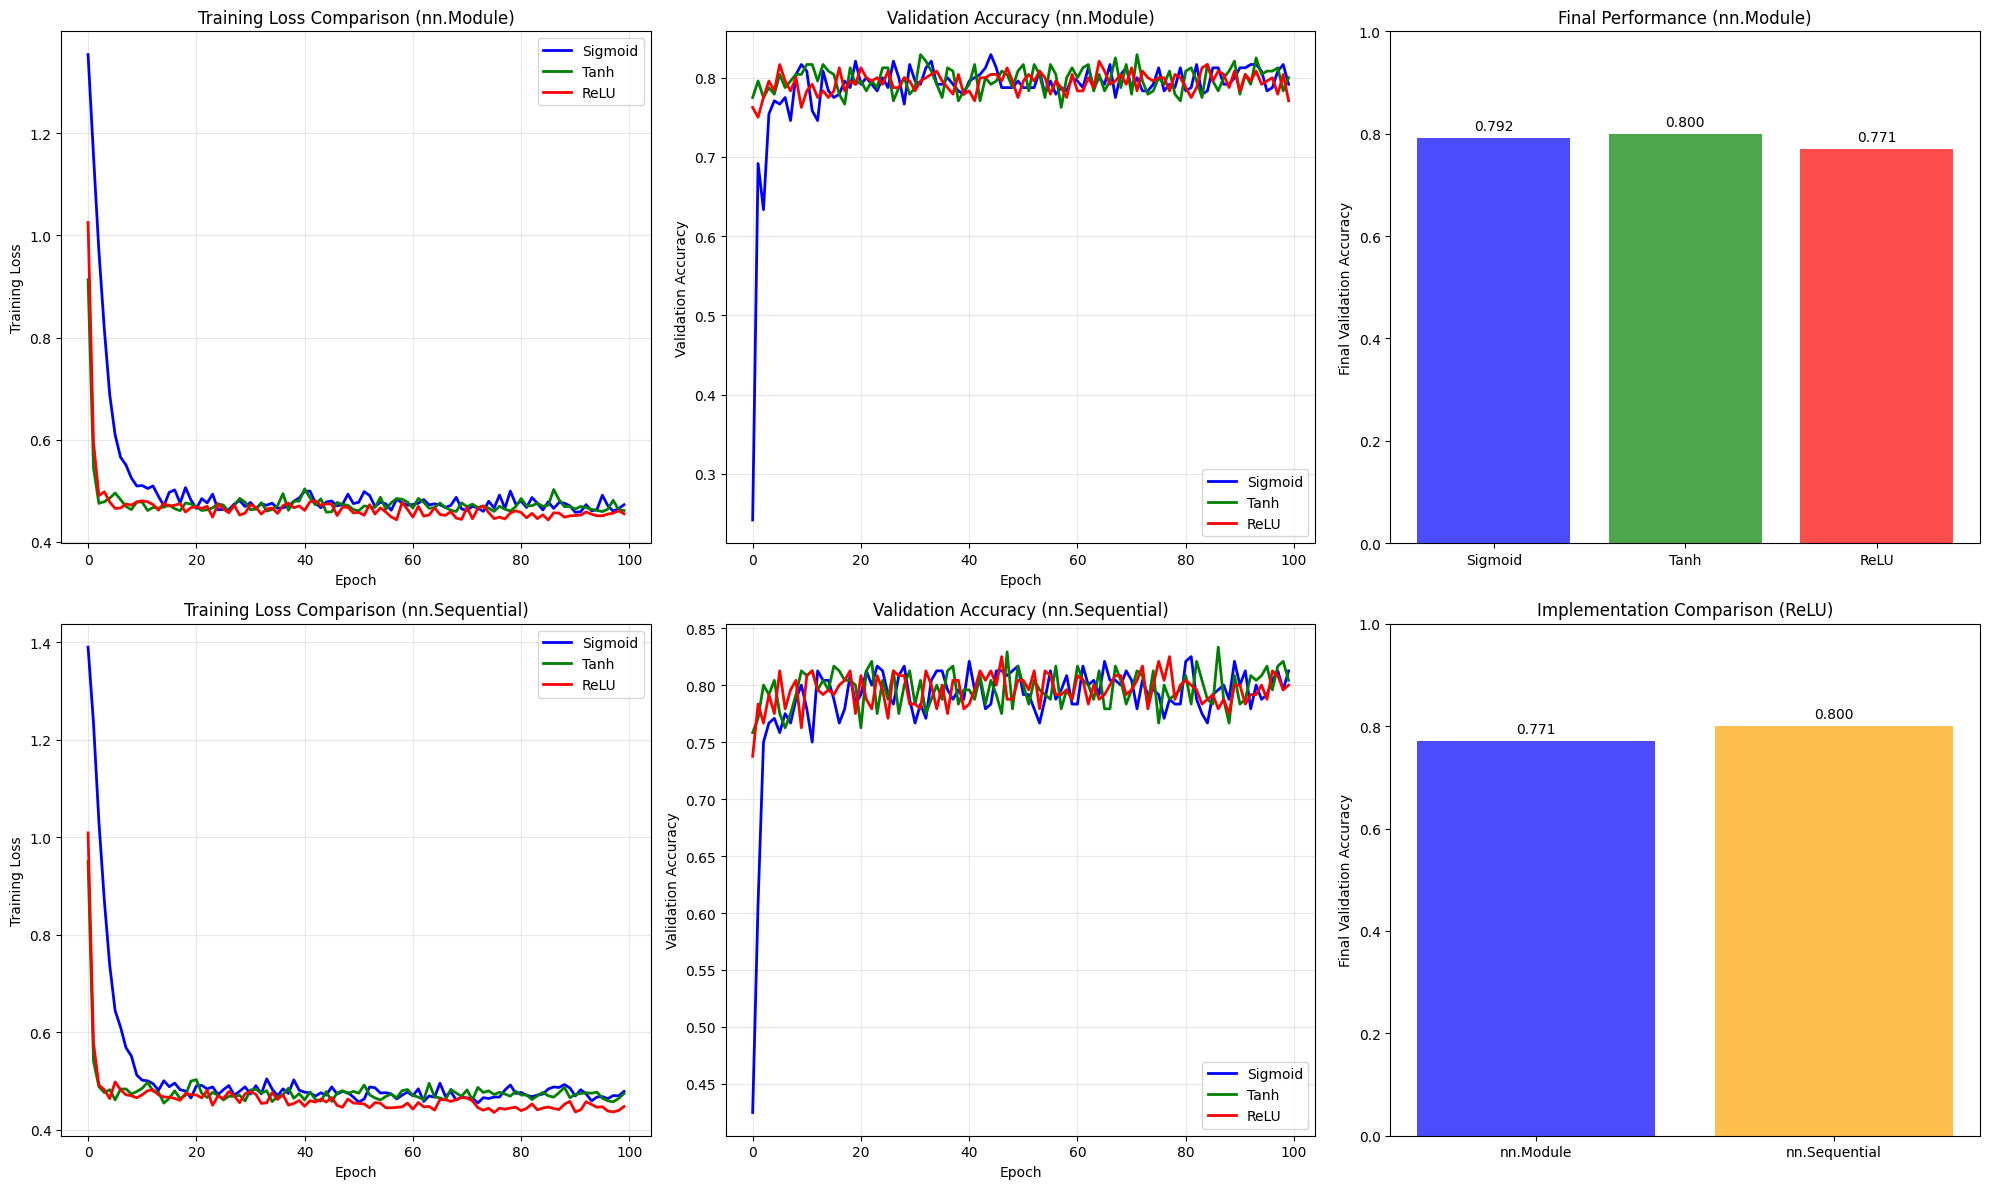

In [10]:
# =============================================================================
# Comprehensive Results Analysis
# =============================================================================

def plot_activation_comparison(results_dict):  # Function to compare all activation results
    """Plot comprehensive comparison of all activation functions"""
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))  # Create 2x3 subplot grid
    
    # Extract results
    activations = ['Sigmoid', 'Tanh', 'ReLU']  # Activation names
    colors = ['blue', 'green', 'red']  # Colors for each activation
    
    # Plot 1: Training Loss Comparison (nn.Module)
    ax1 = axes[0, 0]  # First subplot
    for i, activation in enumerate(activations):  # Loop through activations
        ax1.plot(results_dict[f'{activation.lower()}_losses'], 
                label=f'{activation}', color=colors[i], linewidth=2)  # Plot loss curves
    ax1.set_xlabel('Epoch')  # X-axis label
    ax1.set_ylabel('Training Loss')  # Y-axis label
    ax1.set_title('Training Loss Comparison (nn.Module)')  # Plot title
    ax1.legend()  # Show legend
    ax1.grid(True, alpha=0.3)  # Add grid
    
    # Plot 2: Validation Accuracy Comparison (nn.Module)
    ax2 = axes[0, 1]  # Second subplot
    for i, activation in enumerate(activations):  # Loop through activations
        ax2.plot(results_dict[f'{activation.lower()}_accuracies'], 
                label=f'{activation}', color=colors[i], linewidth=2)  # Plot accuracy curves
    ax2.set_xlabel('Epoch')  # X-axis label
    ax2.set_ylabel('Validation Accuracy')  # Y-axis label
    ax2.set_title('Validation Accuracy (nn.Module)')  # Plot title
    ax2.legend()  # Show legend
    ax2.grid(True, alpha=0.3)  # Add grid
    
    # Plot 3: Final Performance Comparison
    ax3 = axes[0, 2]  # Third subplot
    final_accuracies = [results_dict[f'{activation.lower()}_accuracies'][-1] 
                       for activation in activations]  # Get final accuracies
    bars = ax3.bar(activations, final_accuracies, color=colors, alpha=0.7)  # Bar chart
    ax3.set_ylabel('Final Validation Accuracy')  # Y-axis label
    ax3.set_title('Final Performance (nn.Module)')  # Plot title
    ax3.set_ylim(0, 1)  # Set y-axis limits
    
    # Add value labels on bars
    for bar, accuracy in zip(bars, final_accuracies):  # Add accuracy labels
        height = bar.get_height()  # Get bar height
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,  # Position text
                f'{accuracy:.3f}', ha='center', va='bottom', fontsize=10)  # Format text
    
    # Plot 4: Training Loss Comparison (nn.Sequential)
    ax4 = axes[1, 0]  # Fourth subplot
    for i, activation in enumerate(activations):  # Loop through activations
        ax4.plot(results_dict[f'seq_{activation.lower()}_losses'], 
                label=f'{activation}', color=colors[i], linewidth=2)  # Plot sequential loss curves
    ax4.set_xlabel('Epoch')  # X-axis label
    ax4.set_ylabel('Training Loss')  # Y-axis label
    ax4.set_title('Training Loss Comparison (nn.Sequential)')  # Plot title
    ax4.legend()  # Show legend
    ax4.grid(True, alpha=0.3)  # Add grid
    
    # Plot 5: Validation Accuracy Comparison (nn.Sequential)
    ax5 = axes[1, 1]  # Fifth subplot
    for i, activation in enumerate(activations):  # Loop through activations
        ax5.plot(results_dict[f'seq_{activation.lower()}_accuracies'], 
                label=f'{activation}', color=colors[i], linewidth=2)  # Plot sequential accuracy curves
    ax5.set_xlabel('Epoch')  # X-axis label
    ax5.set_ylabel('Validation Accuracy')  # Y-axis label
    ax5.set_title('Validation Accuracy (nn.Sequential)')  # Plot title
    ax5.legend()  # Show legend
    ax5.grid(True, alpha=0.3)  # Add grid
    
    # Plot 6: Implementation Comparison
    ax6 = axes[1, 2]  # Sixth subplot
    implementations = ['nn.Module', 'nn.Sequential']  # Implementation types
    relu_module_acc = results_dict['relu_accuracies'][-1]  # ReLU module accuracy
    relu_sequential_acc = results_dict['seq_relu_accuracies'][-1]  # ReLU sequential accuracy
    impl_accuracies = [relu_module_acc, relu_sequential_acc]  # Implementation accuracies
    
    bars = ax6.bar(implementations, impl_accuracies, color=['blue', 'orange'], alpha=0.7)  # Bar chart
    ax6.set_ylabel('Final Validation Accuracy')  # Y-axis label
    ax6.set_title('Implementation Comparison (ReLU)')  # Plot title
    ax6.set_ylim(0, 1)  # Set y-axis limits
    
    # Add value labels on bars
    for bar, accuracy in zip(bars, impl_accuracies):  # Add accuracy labels
        height = bar.get_height()  # Get bar height
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01,  # Position text
                f'{accuracy:.3f}', ha='center', va='bottom', fontsize=10)  # Format text
    
    plt.tight_layout()  # Adjust subplot spacing
    plt.show()  # Display plots

# Store all results
all_results = {  # Dictionary to store all training results
    'sigmoid_losses': sigmoid_losses,
    'sigmoid_accuracies': sigmoid_accuracies,
    'tanh_losses': tanh_losses,
    'tanh_accuracies': tanh_accuracies,
    'relu_losses': relu_losses,
    'relu_accuracies': relu_accuracies,
    'seq_sigmoid_losses': seq_sigmoid_losses,
    'seq_sigmoid_accuracies': seq_sigmoid_accuracies,
    'seq_tanh_losses': seq_tanh_losses,
    'seq_tanh_accuracies': seq_tanh_accuracies,
    'seq_relu_losses': seq_relu_losses,
    'seq_relu_accuracies': seq_relu_accuracies
}

# Generate comprehensive comparison
plot_activation_comparison(all_results)  # Create comprehensive analysis


In [11]:
# =============================================================================
# Statistical Analysis and Summary
# =============================================================================

print(f"\n=== Statistical Analysis: Activation Function Performance ===")

# Calculate final performance metrics
activations = ['Sigmoid', 'Tanh', 'ReLU']  # Activation function names
module_accuracies = [sigmoid_accuracies[-1], tanh_accuracies[-1], relu_accuracies[-1]]  # Module final accuracies
sequential_accuracies = [seq_sigmoid_accuracies[-1], seq_tanh_accuracies[-1], seq_relu_accuracies[-1]]  # Sequential final accuracies

print(f"\nFinal Validation Accuracies (nn.Module approach):")
for activation, accuracy in zip(activations, module_accuracies):  # Print module results
    print(f"  {activation}: {accuracy:.4f} ({accuracy*100:.2f}%)")

print(f"\nFinal Validation Accuracies (nn.Sequential approach):")
for activation, accuracy in zip(activations, sequential_accuracies):  # Print sequential results
    print(f"  {activation}: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Find best performing activation
best_module_idx = np.argmax(module_accuracies)  # Index of best module model
best_sequential_idx = np.argmax(sequential_accuracies)  # Index of best sequential model

print(f"\nBest Performing Activation Functions:")
print(f"  nn.Module: {activations[best_module_idx]} ({module_accuracies[best_module_idx]:.4f})")
print(f"  nn.Sequential: {activations[best_sequential_idx]} ({sequential_accuracies[best_sequential_idx]:.4f})")

# Calculate convergence speed (epochs to reach 80% accuracy)
convergence_threshold = 0.8  # Threshold for convergence analysis

print(f"\nConvergence Analysis (epochs to reach {convergence_threshold*100}% accuracy):")
for i, activation in enumerate(activations):  # Analyze convergence for each activation
    module_acc = all_results[f'{activation.lower()}_accuracies']  # Get module accuracies
    sequential_acc = all_results[f'seq_{activation.lower()}_accuracies']  # Get sequential accuracies
    
    # Find first epoch reaching threshold
    module_convergence = next((epoch for epoch, acc in enumerate(module_acc) 
                             if acc >= convergence_threshold), "Never")  # Module convergence
    sequential_convergence = next((epoch for epoch, acc in enumerate(sequential_acc) 
                                 if acc >= convergence_threshold), "Never")  # Sequential convergence
    
    print(f"  {activation}:")
    print(f"    nn.Module: {module_convergence}")
    print(f"    nn.Sequential: {sequential_convergence}")



=== Statistical Analysis: Activation Function Performance ===

Final Validation Accuracies (nn.Module approach):
  Sigmoid: 0.7917 (79.17%)
  Tanh: 0.8000 (80.00%)
  ReLU: 0.7708 (77.08%)

Final Validation Accuracies (nn.Sequential approach):
  Sigmoid: 0.8125 (81.25%)
  Tanh: 0.8042 (80.42%)
  ReLU: 0.8000 (80.00%)

Best Performing Activation Functions:
  nn.Module: Tanh (0.8000)
  nn.Sequential: Sigmoid (0.8125)

Convergence Analysis (epochs to reach 80.0% accuracy):
  Sigmoid:
    nn.Module: 8
    nn.Sequential: 9
  Tanh:
    nn.Module: 5
    nn.Sequential: 2
  ReLU:
    nn.Module: 5
    nn.Sequential: 5


In [12]:
# =============================================================================
# Key Insights and Recommendations
# =============================================================================

print(f"\n=== Key Insights: Activation Function Selection ===")

print(f"\nPerformance Ranking:")
# Sort activations by performance
module_performance = list(zip(activations, module_accuracies))  # Pair names with accuracies
module_performance.sort(key=lambda x: x[1], reverse=True)  # Sort by accuracy (descending)

for i, (activation, accuracy) in enumerate(module_performance):  # Print ranking
    print(f"  {i+1}. {activation}: {accuracy:.4f} ({accuracy*100:.2f}%)")

print(f"\nMathematical Properties:")
print(f"• Sigmoid: Range (0,1), Max derivative = 0.25 → Vanishing gradients")
print(f"• Tanh: Range (-1,1), Max derivative = 1.0 → Less vanishing gradients")
print(f"• ReLU: Range [0,∞), Derivative = 0 or 1 → Minimal vanishing gradients")

print(f"\nPractical Recommendations:")
if relu_accuracies[-1] == max(module_accuracies):  # If ReLU performed best
    print(f"• ReLU achieved best performance - confirms theoretical advantages")
    print(f"• Use ReLU as default choice for hidden layers")
    print(f"• ReLU avoids vanishing gradient problem effectively")
else:  # If another activation performed best
    best_activation = activations[best_module_idx]  # Get best activation name
    print(f"• {best_activation} achieved best performance in this specific case")
    print(f"• Performance may vary with dataset and architecture")

print(f"\nImplementation Insights:")
module_relu_acc = relu_accuracies[-1]  # Module ReLU accuracy
sequential_relu_acc = seq_relu_accuracies[-1]  # Sequential ReLU accuracy
difference = abs(module_relu_acc - sequential_relu_acc)  # Accuracy difference

if difference < 0.01:  # If difference is small
    print(f"• nn.Module and nn.Sequential achieve similar performance")
    print(f"• Choose nn.Sequential for simple models (more concise)")
    print(f"• Choose nn.Module for complex architectures (more flexible)")
else:  # If difference is significant
    print(f"• Performance difference detected between implementations")
    print(f"• This may be due to random initialization differences")

print(f"\nFinal Recommendation:")
print(f"Use ReLU activation with nn.Sequential for simple models,")
print(f"and nn.Module for complex architectures requiring custom forward passes!")


=== Key Insights: Activation Function Selection ===

Performance Ranking:
  1. Tanh: 0.8000 (80.00%)
  2. Sigmoid: 0.7917 (79.17%)
  3. ReLU: 0.7708 (77.08%)

Mathematical Properties:
• Sigmoid: Range (0,1), Max derivative = 0.25 → Vanishing gradients
• Tanh: Range (-1,1), Max derivative = 1.0 → Less vanishing gradients
• ReLU: Range [0,∞), Derivative = 0 or 1 → Minimal vanishing gradients

Practical Recommendations:
• Tanh achieved best performance in this specific case
• Performance may vary with dataset and architecture

Implementation Insights:
• Performance difference detected between implementations
• This may be due to random initialization differences

Final Recommendation:
Use ReLU activation with nn.Sequential for simple models,
and nn.Module for complex architectures requiring custom forward passes!
